Tutorial 7: Results And Samples
===============================

In this tutorial, we'll cover all of the output that comes from a `NonLinearSearch` in the form of a `Result` object.

We used this object at various points in the chapter, and the bulk of material covered here is described in the example
script `autofit_workspace/overview/simple/result.py`. Nevertheless, it is a good idea to refresh ourselves about how
results in **PyAutoFit** work before covering more advanced material.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import os
from os import path
import numpy as np
import matplotlib.pyplot as plt

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


Load the dataset from the `autofit_workspace/dataset` folder.

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

We'll reuse the `plot_line` and `Analysis` classes of the previous tutorial.

In [3]:


def plot_line(
    xvalues,
    line,
    title=None,
    ylabel=None,
    errors=None,
    color="k",
    output_path=None,
    output_filename=None,
):

    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color=color, ecolor="k", elinewidth=1, capsize=2
    )
    plt.title(title)
    plt.xlabel("x value of profile")
    plt.ylabel(ylabel)
    if not path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(path.join(output_path, f"{output_filename}.png"))
    plt.clf()


class Analysis(af.Analysis):
    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        model_data = self.model_data_from_instance(instance=instance)

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood

    def model_data_from_instance(self, instance):

        """
        To create the summed profile of all individual profiles in an instance, we can use a dictionary comprehension
        to iterate over all profiles in the instance.
        """
        xvalues = np.arange(self.data.shape[0])

        return sum(
            [profile.profile_from_xvalues(xvalues=xvalues) for profile in instance]
        )

    def visualize(self, paths, instance, during_analysis):

        """
        This method is identical to the previous tutorial, except it now uses the `model_data_from_instance` method
        to create the profile.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = self.model_data_from_instance(instance=instance)

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0

        """The visualizer now outputs images of the best-fit results to hard-disk (checkout `visualizer.py`)."""
        plot_line(
            xvalues=xvalues,
            line=self.data,
            title="Data",
            ylabel="Data Values",
            color="k",
            output_path=paths.image_path,
            output_filename="data",
        )

        plot_line(
            xvalues=xvalues,
            line=model_data,
            title="Model Data",
            ylabel="Model Data Values",
            color="k",
            output_path=paths.image_path,
            output_filename="model_data",
        )

        plot_line(
            xvalues=xvalues,
            line=residual_map,
            title="Residual Map",
            ylabel="Residuals",
            color="k",
            output_path=paths.image_path,
            output_filename="residual_map",
        )

        plot_line(
            xvalues=xvalues,
            line=chi_squared_map,
            title="Chi-Squared Map",
            ylabel="Chi-Squareds",
            color="k",
            output_path=paths.image_path,
            output_filename="chi_squared_map",
        )


Now lets run the `NonLinearSearch` to get ourselves a `Result`.

In [4]:
import profiles as p

model = af.Collection(gaussian=p.Gaussian)

analysis = Analysis(data=data, noise_map=noise_map)

emcee = af.Emcee(
    name="tutorial_6_results_and_samples",
    path_prefix=path.join("howtofit", "chapter_1"),
)

print(
    "Emcee has begun running. \n"
    "Checkout the autofit_workspace/output/howtofit/tutorial_6__results_and_samples \n"
    "folder for live output of the results.\n"
    "This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!"
)

result = emcee.fit(model=model, analysis=analysis)

print("Emcee has finished run - you may now continue the notebook.")

2021-05-11 20:03:24,812 - root - INFO - tutorial_6_results_and_samples already completed, skipping non-linear search.


Emcee has begun running. 
Checkout the autofit_workspace/output/howtofit/tutorial_6__results_and_samples 
folder for live output of the results.
This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!
Emcee has finished run - you may now continue the notebook.


__Result__

Here, we'll look in detail at what information is contained in the `Result`.

It contains a `Samples` object, which contains information on the `NonLinearSearch`, for example the parameters. 

The parameters are stored as a list of lists, where:

 - The outer list is the size of the total number of samples.
 - The inner list is the size of the number of free parameters in the fit.

In [5]:
samples = result.samples
print("Sample 50's second parameter value (Gaussian -> intensity):")
print(samples.parameter_lists[49][1])
print("Sample 10`s third parameter value (Gaussian -> sigma)")
print(samples.parameter_lists[9][2], "\n")

Sample 50's second parameter value (Gaussian -> intensity):
0.9478903232613977
Sample 10`s third parameter value (Gaussian -> sigma)
12.637154460396557 



The `Samples` class also contains the `log_likelihood_list`, `log_prior_list`, `log_posterior_list` and `weight_list` of every 
accepted sample, where:

 - A `log_likelihood` is the value evaluated from the `log_likelihood_function` (e.g. -0.5 * `chi_squared` + the 
 `noise_normalization`).

 - The `log_prior` encodes information on how the priors on the parameters maps the `log_likelihood` value to the 
  `log_posterior` value.

 - The `log_posterior` is `log_likelihood` + `log_prior`.

 - The `weight_list` gives information on how samples should be combined to estimate the posterior. The values 
   depend on the `NonLinearSearch` used, for MCMC samples they are all 1 (e.g. all weighted equally).
   
Lets inspect the last 10 values of each for the analysis.

In [6]:
print("Final 10 Log Likelihoods:")
print(samples.log_likelihood_list[-10:])

print("Final 10 Log Priors:")
print(samples.log_prior_list[-10:])

print("Final 10 Log Posteriors:")
print(samples.log_posterior_list[-10:])

print("Final 10 Sample Weights:")
print(samples.weight_list[-10:], "\n")

Final 10 Log Likelihoods:
[172.3947255855608, 172.113789598824, 173.03051402991872, 172.87802285298307, 173.24534247088542, 174.24815320945186, 174.92734610260788, 174.26893857684118, 175.02554936925708, 174.40764482259593]
Final 10 Log Priors:
[0.04101161700409956, 0.03882932032049405, 0.03982699591971434, 0.040735593162923196, 0.03924873786543247, 0.04058743851395109, 0.03992257826009923, 0.040095999353221466, 0.03980184427062066, 0.03965072084135935]
Final 10 Log Posteriors:
[172.4357372025649, 172.15261891914452, 173.07034102583845, 172.918758446146, 173.28459120875084, 174.2887406479658, 174.967268680868, 174.3090345761944, 175.0653512135277, 174.4472955434373]
Final 10 Sample Weights:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



The `Samples` contain many useful vectors, including the the maximum log likelihood and posterior values:

In [7]:
max_log_likelihood_vector = samples.max_log_likelihood_vector
max_log_posterior_vector = samples.max_log_posterior_vector

print("Maximum Log Likelihood Vector:")
print(max_log_likelihood_vector)

print("Maximum Log Posterior Vector:")
print(max_log_posterior_vector, "\n")

Maximum Log Likelihood Vector:
[50.005794785124564, 24.98668276978214, 10.26199063946251]
Maximum Log Posterior Vector:
[50.005794785124564, 24.98668276978214, 10.26199063946251] 



This provides us with lists of all model parameters. However, this isn't that much use, which values correspond to 
which parameters?

The list of parameter names are available as a property of the `Model` included with the `Samples`, as are labels 
which can be used for labeling figures.

In [8]:
model = samples.model
print(model)
print(model.parameter_names)
print(model.parameter_labels)
print("\n")

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0)
['centre', 'intensity', 'sigma']
['x', 'I', 'sigma']




It is more useful to return the `Result`'s as an `instance`, which is an instance of the `model` using the Python 
classes used to compose it.

In [9]:
max_log_likelihood_instance = samples.max_log_likelihood_instance

A `model instance` contains all the model components of our fit, which for the fit above was a single `Gaussian`
profile (the word `gaussian` comes from what we called it in the `Collection` above).

In [10]:
print(max_log_likelihood_instance.gaussian)

We can unpack the parameters of the `Gaussian` to reveal the `max_log_likelihood_instance`:

In [11]:
print("Max Log Likelihood `Gaussian` Instance:")
print("Centre = ", max_log_likelihood_instance.gaussian.centre)
print("Intensity = ", max_log_likelihood_instance.gaussian.intensity)
print("Sigma = ", max_log_likelihood_instance.gaussian.sigma, "\n")

Max Log Likelihood `Gaussian` Instance:
Centre =  50.005794785124564
Intensity =  24.98668276978214
Sigma =  10.26199063946251 



For our example problem of fitting a 1D `Gaussian` profile, this makes it straight forward to plot the 
`max_log_likelihood_instance`:

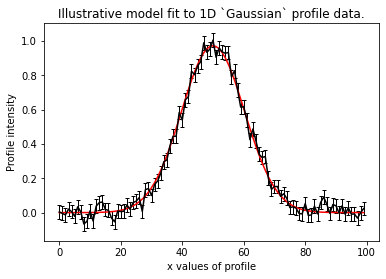

In [12]:
xvalues = np.arange(data.shape[0])
model_data = samples.max_log_likelihood_instance.gaussian.profile_from_xvalues(
    xvalues=xvalues
)

import matplotlib.pyplot as plt

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Illustrative model fit to 1D `Gaussian` profile data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

We can also access the `median PDF` model, which is the model computed by marginalizing over the samples of every 
parameter in 1D and taking the median of this PDF.

The `median_pdf_vector` is readily available from the `Samples` object for you convenience.

In [13]:
median_pdf_vector = samples.median_pdf_vector
print("Median PDF Vector:")
print(median_pdf_vector, "\n")

median_pdf_instance = samples.median_pdf_instance
print("Median PDF `Gaussian` Instance:")
print("Centre = ", median_pdf_instance.gaussian.centre)
print("Intensity = ", median_pdf_instance.gaussian.intensity)
print("Sigma = ", median_pdf_instance.gaussian.sigma, "\n")

Median PDF Vector:
[50.001427636679686, 24.977559736727258, 10.255923770512812] 

Median PDF `Gaussian` Instance:
Centre =  50.001427636679686
Intensity =  24.977559736727258
Sigma =  10.255923770512812 



The `Samples` class also provides methods for computing the error estimates of all parameters at an input sigma 
confidence limit, which can be returned as the values of the parameters including their errors or the size of the 
errors on each parameter:

In [14]:
vector_at_upper_sigma = samples.vector_at_upper_sigma(sigma=3.0)
vector_at_lower_sigma = samples.vector_at_lower_sigma(sigma=3.0)

print("Upper Parameter values w/ error (at 3.0 sigma confidence):")
print(vector_at_upper_sigma)
print("lower Parameter values w/ errors (at 3.0 sigma confidence):")
print(vector_at_lower_sigma, "\n")

error_vector_at_upper_sigma = samples.error_vector_at_upper_sigma(sigma=3.0)
error_vector_at_lower_sigma = samples.error_vector_at_lower_sigma(sigma=3.0)

print("Upper Error values (at 3.0 sigma confidence):")
print(error_vector_at_upper_sigma)
print("lower Error values (at 3.0 sigma confidence):")
print(error_vector_at_lower_sigma, "\n")

Upper Parameter values w/ error (at 3.0 sigma confidence):
[50.347095811657546, 25.814388869644617, 10.62664572750715]
lower Parameter values w/ errors (at 3.0 sigma confidence):
[49.60514379426283, 24.154736460132746, 9.885419108961907] 

Upper Error values (at 3.0 sigma confidence):
[0.3456681749778596, 0.8368291329173587, 0.37072195699433763]
lower Error values (at 3.0 sigma confidence):
[0.39628384241685666, 0.8228232765945123, 0.3705046615509051] 



All methods above are available as an `instance`:

In [15]:
instance_at_upper_sigma = samples.instance_at_upper_sigma
instance_at_lower_sigma = samples.instance_at_lower_sigma
error_instance_at_upper_sigma = samples.error_instance_at_upper_sigma
error_instance_at_lower_sigma = samples.error_instance_at_lower_sigma

An `instance` of any accepted parameter space sample can be created:

In [16]:
instance = samples.instance_from_sample_index(sample_index=500)
print("Gaussian Instance of sample 5000:")
print("Centre = ", instance.gaussian.centre)
print("Intensity = ", instance.gaussian.intensity)
print("Sigma = ", instance.gaussian.sigma, "\n")

Gaussian Instance of sample 5000:
Centre =  49.79744604225628
Intensity =  1.3164184654735356
Sigma =  12.499665891053342 



Because `Emcee`, an MCMC *NonLinearSearch* was used, the `log_evidence` of the model is not available. However, if a 
nested sampling algorithm such as `DynestyStatic` had been used the Bayesian evidence would of been available to 
perform model (the log evidence below gives `None`)..

In [17]:
print(samples.log_evidence)

None


The Probability Density Functions (PDF's) of the results can be plotted using the library:

 `corner.py`: https://corner.readthedocs.io/en/latest/

(In built visualization for PDF's and `NonLinearSearch`'s is a future feature of **PyAutoFit**, but for now you'll 
have to use the libraries yourself!).

2021-05-11 20:03:34,523 - root - WARNING - Too few points to create valid contours
2021-05-11 20:03:34,621 - root - WARNING - Too few points to create valid contours
2021-05-11 20:03:34,645 - root - WARNING - Too few points to create valid contours


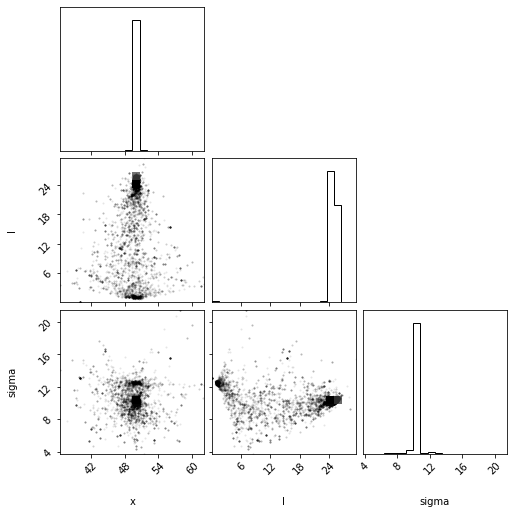

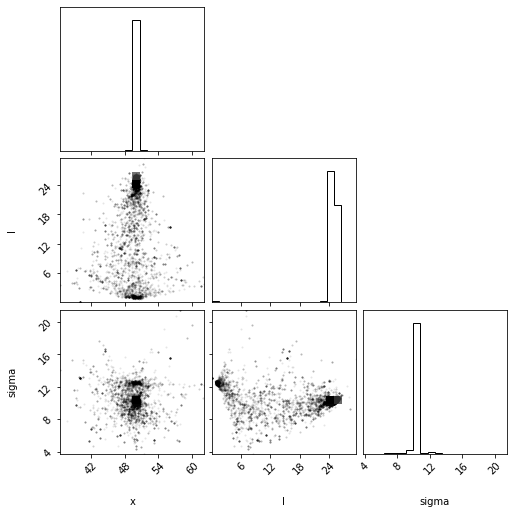

In [18]:
import corner

corner.corner(
    data=samples.parameter_lists,
    weight_list=samples.weight_list,
    labels=samples.model.parameter_labels,
)

Finish.